## 1. Setup and Configuration

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import utils

# Technical indicators library
import ta
from ta.trend import SMAIndicator, EMAIndicator, MACD, ADXIndicator
from ta.momentum import RSIIndicator, ROCIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, VolumeWeightedAveragePrice

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)

print("Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully
Pandas version: 2.2.2
NumPy version: 1.26.4


In [22]:
# Configure plotting styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("Plotting configuration set")

Plotting configuration set


In [23]:
# Define paths and constants
DATA_DIR = '../data/'
PROCESSED_DIR = '../data/processed/'
RESULTS_DIR = '../results/'
FIGURES_DIR = '../results/figures/feature_engineering/'

# Create directories if they don't exist
import os
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# Asset information
ASSETS = {
    'AAPL': {'name': 'Apple Inc.', 'type': 'Tech Stock', 'volatility': 'Low-Medium'},
    'AMZN': {'name': 'Amazon.com Inc.', 'type': 'Tech Stock', 'volatility': 'Medium'},
    'NVDA': {'name': 'NVIDIA Corporation', 'type': 'Tech Stock', 'volatility': 'Medium-High'},
    'BTC': {'name': 'Bitcoin', 'type': 'Cryptocurrency', 'volatility': 'Very High'}
}

# Prediction horizons (in hours)
PREDICTION_HORIZONS = {
    'stocks': {
        '1hour': 1,
        '1day': 7,      # ~7 trading hours
        '1week': 35,    # 5 trading days * 7 hours
        '1month': 140   # 20 trading days * 7 hours
    },
    'btc': {
        '1hour': 1,
        '1day': 24,     # 24 hours
        '1week': 168,   # 7 days * 24 hours
        '1month': 720   # 30 days * 24 hours
    }
}

print("Configuration complete")
print(f"\nAssets to process: {list(ASSETS.keys())}")
print(f"Output directory: {PROCESSED_DIR}")

Configuration complete

Assets to process: ['AAPL', 'AMZN', 'NVDA', 'BTC']
Output directory: ../data/processed/


## 2. Load Raw Data

Load the cleaned OHLCV data from Notebook 01.

In [24]:
# Load all assets
data = {}
for asset in ASSETS.keys():
    data[asset] = utils.load_asset_data(asset, DATA_DIR)
    print(f"{asset}: {len(data[asset])} records loaded")

print("\n[OK] All data loaded successfully")

[OK] Loaded AAPL: 3480 rows, 6 columns
AAPL: 3480 records loaded
[OK] Loaded AMZN: 3480 rows, 6 columns
AMZN: 3480 records loaded
[OK] Loaded NVDA: 3480 rows, 6 columns
NVDA: 3480 records loaded
[OK] Loaded BTC: 17520 rows, 5 columns
BTC: 17520 records loaded

[OK] All data loaded successfully
[OK] Loaded BTC: 17520 rows, 5 columns
BTC: 17520 records loaded

[OK] All data loaded successfully


## 3. Feature Engineering Functions

Define functions to calculate various feature categories.

In [25]:
def add_price_features(df):
    """
    Add price-based features.
    """
    df = df.copy()
    
    # Price ratios
    df['close_to_open_ratio'] = df['close'] / df['open']
    df['high_to_low_ratio'] = df['high'] / df['low']
    df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3
    
    # Price ranges
    df['price_range'] = df['high'] - df['low']
    df['price_range_pct'] = df['price_range'] / df['close']
    
    return df

print("[OK] Price features function defined")

[OK] Price features function defined


In [26]:
def add_volume_features(df):
    """
    Add volume-based features.
    """
    df = df.copy()
    
    # Volume changes
    df['volume_change'] = df['volume'].pct_change()
    df['volume_change'] = df['volume_change'].replace([np.inf, -np.inf], 0)
    
    # Volume moving averages
    df['volume_sma_20'] = df['volume'].rolling(window=20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_sma_20']
    
    return df

print("[OK] Volume features function defined")

[OK] Volume features function defined


In [27]:
def add_technical_indicators(df):
    """
    Add comprehensive technical indicators using the ta library.
    """
    df = df.copy()
    
    # Momentum Indicators
    df['rsi_14'] = RSIIndicator(close=df['close'], window=14).rsi()
    df['rsi_21'] = RSIIndicator(close=df['close'], window=21).rsi()
    
    # MACD
    macd = MACD(close=df['close'], window_slow=26, window_fast=12, window_sign=9)
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = macd.macd_diff()
    
    # Rate of Change
    df['roc_12'] = ROCIndicator(close=df['close'], window=12).roc()
    df['roc_24'] = ROCIndicator(close=df['close'], window=24).roc()
    
    # Trend Indicators
    df['sma_20'] = SMAIndicator(close=df['close'], window=20).sma_indicator()
    df['sma_50'] = SMAIndicator(close=df['close'], window=50).sma_indicator()
    df['sma_200'] = SMAIndicator(close=df['close'], window=200).sma_indicator()
    
    df['ema_12'] = EMAIndicator(close=df['close'], window=12).ema_indicator()
    df['ema_26'] = EMAIndicator(close=df['close'], window=26).ema_indicator()
    
    # Price distance from moving averages
    df['close_to_sma20'] = (df['close'] - df['sma_20']) / df['sma_20']
    df['close_to_sma50'] = (df['close'] - df['sma_50']) / df['sma_50']
    
    # Bollinger Bands
    bollinger = BollingerBands(close=df['close'], window=20, window_dev=2)
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_mid'] = bollinger.bollinger_mavg()
    df['bb_low'] = bollinger.bollinger_lband()
    df['bb_width'] = (df['bb_high'] - df['bb_low']) / df['bb_mid']
    df['bb_position'] = (df['close'] - df['bb_low']) / (df['bb_high'] - df['bb_low'])
    
    # ADX (Trend Strength)
    adx = ADXIndicator(high=df['high'], low=df['low'], close=df['close'], window=14)
    df['adx'] = adx.adx()
    
    # Volatility Indicators
    df['atr_14'] = AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=14).average_true_range()
    df['atr_ratio'] = df['atr_14'] / df['close']
    
    # Historical Volatility
    returns = np.log(df['close'] / df['close'].shift(1))
    df['hist_vol_20'] = returns.rolling(window=20).std()
    df['hist_vol_50'] = returns.rolling(window=50).std()
    
    # Volume Indicators
    df['obv'] = OnBalanceVolumeIndicator(close=df['close'], volume=df['volume']).on_balance_volume()
    df['vwap'] = VolumeWeightedAveragePrice(high=df['high'], low=df['low'], close=df['close'], volume=df['volume']).volume_weighted_average_price()
    df['close_to_vwap'] = (df['close'] - df['vwap']) / df['vwap']
    
    return df

print("[OK] Technical indicators function defined")
print("  - Momentum: RSI, MACD, ROC")
print("  - Trend: SMA, EMA, Bollinger Bands, ADX")
print("  - Volatility: ATR, Historical Volatility")
print("  - Volume: OBV, VWAP")

[OK] Technical indicators function defined
  - Momentum: RSI, MACD, ROC
  - Trend: SMA, EMA, Bollinger Bands, ADX
  - Volatility: ATR, Historical Volatility
  - Volume: OBV, VWAP


In [28]:
def add_returns_features(df):
    """
    Add returns and lagged returns features.
    """
    df = df.copy()
    
    # Log returns
    df['returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # Lagged returns
    for lag in [1, 3, 6, 12, 24]:
        df[f'returns_lag_{lag}'] = df['returns'].shift(lag)
    
    # Cumulative returns
    df['cumulative_returns_24'] = df['returns'].rolling(window=24).sum()
    df['cumulative_returns_168'] = df['returns'].rolling(window=168).sum()
    
    return df

print("[OK] Returns features function defined")

[OK] Returns features function defined


In [29]:
def add_time_features(df):
    """
    Add time-based features with cyclical encoding.
    """
    df = df.copy()
    
    # Extract time components
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    
    # Cyclical encoding for hour (0-23)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Cyclical encoding for day of week (0-6)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Cyclical encoding for month (1-12)
    df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)
    df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)
    
    # Market hours indicator (for stocks)
    # US market: 9:30 AM - 4:00 PM EST (approx 14:30 - 21:00 UTC)
    df['is_market_hours'] = ((df['hour'] >= 14) & (df['hour'] < 21)).astype(int)
    
    return df

print("[OK] Time features function defined")

[OK] Time features function defined


In [30]:
def add_volatility_regime_features(df):
    """
    Add volatility regime classification features.
    """
    df = df.copy()
    
    # Calculate realized volatility (20-hour rolling)
    returns = np.log(df['close'] / df['close'].shift(1))
    df['realized_vol_20'] = returns.rolling(window=20).std()
    df['realized_vol_100'] = returns.rolling(window=100).std()
    
    # Volatility ratio
    df['vol_ratio'] = df['realized_vol_20'] / df['realized_vol_100']
    
    # Volatility regime based on percentiles
    vol_percentiles = df['realized_vol_20'].quantile([0.33, 0.67])
    df['vol_regime'] = pd.cut(df['realized_vol_20'], 
                               bins=[0, vol_percentiles.iloc[0], vol_percentiles.iloc[1], np.inf],
                               labels=[0, 1, 2])  # 0=low, 1=medium, 2=high
    df['vol_regime'] = df['vol_regime'].astype(float)
    
    return df

print("[OK] Volatility regime features function defined")

[OK] Volatility regime features function defined


## 4. Apply Feature Engineering

Apply all feature engineering functions to each asset.

In [31]:
# Store engineered features
features_data = {}

print("="*80)
print("FEATURE ENGINEERING PIPELINE")
print("="*80)

for asset, df in data.items():
    print(f"\nProcessing {asset} ({ASSETS[asset]['name']})...")
    
    # Start with copy of original data
    df_features = df.copy()
    initial_rows = len(df_features)
    
    # Apply feature engineering
    print("  - Adding price features...")
    df_features = add_price_features(df_features)
    
    print("  - Adding volume features...")
    df_features = add_volume_features(df_features)
    
    print("  - Adding technical indicators...")
    df_features = add_technical_indicators(df_features)
    
    print("  - Adding returns features...")
    df_features = add_returns_features(df_features)
    
    print("  - Adding time features...")
    df_features = add_time_features(df_features)
    
    print("  - Adding volatility regime features...")
    df_features = add_volatility_regime_features(df_features)
    
    # Drop rows with NaN values (from rolling calculations)
    df_features = df_features.dropna()
    final_rows = len(df_features)
    rows_dropped = initial_rows - final_rows
    
    print(f"  [OK] Feature engineering complete")
    print(f"    Initial rows: {initial_rows}")
    print(f"    Final rows: {final_rows}")
    print(f"    Rows dropped (NaN): {rows_dropped}")
    print(f"    Total features: {len(df_features.columns)}")
    
    features_data[asset] = df_features

print("\n" + "="*80)
print("[OK] Feature engineering completed for all assets")
print("="*80)

FEATURE ENGINEERING PIPELINE

Processing AAPL (Apple Inc.)...
  - Adding price features...
  - Adding volume features...
  - Adding technical indicators...
  - Adding technical indicators...
  - Adding returns features...
  - Adding time features...
  - Adding volatility regime features...
  [OK] Feature engineering complete
    Initial rows: 3480
    Final rows: 3281
    Rows dropped (NaN): 199
    Total features: 64

Processing AMZN (Amazon.com Inc.)...
  - Adding price features...
  - Adding volume features...
  - Adding technical indicators...
  - Adding returns features...
  - Adding time features...
  - Adding volatility regime features...
  [OK] Feature engineering complete
    Initial rows: 3480
    Final rows: 3281
    Rows dropped (NaN): 199
    Total features: 64

Processing AMZN (Amazon.com Inc.)...
  - Adding price features...
  - Adding volume features...
  - Adding technical indicators...
  - Adding returns features...
  - Adding time features...
  - Adding volatility re

In [32]:
# Display feature summary for one asset
sample_asset = 'AAPL'
print(f"\nFeature Summary for {sample_asset}:")
print("="*60)
print(f"Shape: {features_data[sample_asset].shape}")
print(f"\nColumns ({len(features_data[sample_asset].columns)}):")
for i, col in enumerate(features_data[sample_asset].columns, 1):
    print(f"  {i:2d}. {col}")


Feature Summary for AAPL:
Shape: (3281, 64)

Columns (64):
   1. datetime
   2. close
   3. high
   4. low
   5. open
   6. volume
   7. close_to_open_ratio
   8. high_to_low_ratio
   9. typical_price
  10. price_range
  11. price_range_pct
  12. volume_change
  13. volume_sma_20
  14. volume_ratio
  15. rsi_14
  16. rsi_21
  17. macd
  18. macd_signal
  19. macd_diff
  20. roc_12
  21. roc_24
  22. sma_20
  23. sma_50
  24. sma_200
  25. ema_12
  26. ema_26
  27. close_to_sma20
  28. close_to_sma50
  29. bb_high
  30. bb_mid
  31. bb_low
  32. bb_width
  33. bb_position
  34. adx
  35. atr_14
  36. atr_ratio
  37. hist_vol_20
  38. hist_vol_50
  39. obv
  40. vwap
  41. close_to_vwap
  42. returns
  43. returns_lag_1
  44. returns_lag_3
  45. returns_lag_6
  46. returns_lag_12
  47. returns_lag_24
  48. cumulative_returns_24
  49. cumulative_returns_168
  50. hour
  51. day_of_week
  52. day_of_month
  53. month
  54. hour_sin
  55. hour_cos
  56. day_sin
  57. day_cos
  58. month_si

## 5. Create Target Variables

Create binary labels for price movement prediction at multiple horizons.

In [33]:
def create_target_variables(df, asset, horizons):
    """
    Create binary target variables for multiple prediction horizons.
    
    Target: 1 if price goes up, 0 if price goes down
    """
    df = df.copy()
    
    targets = {}
    
    for horizon_name, hours in horizons.items():
        # Future close price
        future_close = df['close'].shift(-hours)
        
        # Binary label: 1 if price increases, 0 if decreases
        target = (future_close > df['close']).astype(int)
        
        # Add to dataframe
        df[f'target_{horizon_name}'] = target
        
        # Store separately
        targets[horizon_name] = target
    
    # Remove last 'max_horizon' rows (no future data)
    max_horizon = max(horizons.values())
    df = df.iloc[:-max_horizon]
    
    return df, targets

print("[OK] Target variable creation function defined")

[OK] Target variable creation function defined


In [34]:
# Create targets for all assets
final_data = {}
target_stats = []

print("="*80)
print("TARGET VARIABLE CREATION")
print("="*80)

for asset, df in features_data.items():
    print(f"\n{asset}:")
    
    # Select appropriate horizons
    horizons = PREDICTION_HORIZONS['btc'] if asset == 'BTC' else PREDICTION_HORIZONS['stocks']
    
    # Create targets
    df_with_targets, targets = create_target_variables(df, asset, horizons)
    
    # Calculate class balance
    for horizon_name in horizons.keys():
        target_col = f'target_{horizon_name}'
        if target_col in df_with_targets.columns:
            value_counts = df_with_targets[target_col].value_counts()
            n_up = value_counts.get(1, 0)
            n_down = value_counts.get(0, 0)
            total = n_up + n_down
            pct_up = (n_up / total * 100) if total > 0 else 0
            
            print(f"  {horizon_name:10s}: UP={n_up:5d} ({pct_up:5.1f}%), DOWN={n_down:5d} ({100-pct_up:5.1f}%)")
            
            target_stats.append({
                'Asset': asset,
                'Horizon': horizon_name,
                'Total': total,
                'UP': n_up,
                'DOWN': n_down,
                'UP_pct': pct_up,
                'Balance': 'Balanced' if 45 <= pct_up <= 55 else 'Imbalanced'
            })
    
    final_data[asset] = df_with_targets

print("\n" + "="*80)
print("[OK] Target variables created for all assets")
print("="*80)

TARGET VARIABLE CREATION

AAPL:
  1hour     : UP= 1605 ( 51.1%), DOWN= 1536 ( 48.9%)
  1day      : UP= 1715 ( 54.6%), DOWN= 1426 ( 45.4%)
  1week     : UP= 1775 ( 56.5%), DOWN= 1366 ( 43.5%)
  1month    : UP= 1994 ( 63.5%), DOWN= 1147 ( 36.5%)

AMZN:
  1hour     : UP= 1604 ( 51.1%), DOWN= 1537 ( 48.9%)
  1day      : UP= 1672 ( 53.2%), DOWN= 1469 ( 46.8%)
  1week     : UP= 1778 ( 56.6%), DOWN= 1363 ( 43.4%)
  1month    : UP= 1988 ( 63.3%), DOWN= 1153 ( 36.7%)

NVDA:
  1hour     : UP= 1647 ( 52.4%), DOWN= 1494 ( 47.6%)
  1day      : UP= 1735 ( 55.2%), DOWN= 1406 ( 44.8%)
  1week     : UP= 1910 ( 60.8%), DOWN= 1231 ( 39.2%)
  1month    : UP= 1980 ( 63.0%), DOWN= 1161 ( 37.0%)

BTC:
  1hour     : UP= 8425 ( 50.7%), DOWN= 8176 ( 49.3%)
  1day      : UP= 8778 ( 52.9%), DOWN= 7823 ( 47.1%)
  1week     : UP= 9130 ( 55.0%), DOWN= 7471 ( 45.0%)
  1month    : UP= 9287 ( 55.9%), DOWN= 7314 ( 44.1%)

[OK] Target variables created for all assets
  1hour     : UP= 1647 ( 52.4%), DOWN= 1494 ( 47.6%)
 

In [35]:
# Display target statistics summary
target_stats_df = pd.DataFrame(target_stats)
print("\nTarget Variable Statistics:")
print("="*80)
print(target_stats_df.to_string(index=False))


Target Variable Statistics:
Asset Horizon  Total   UP  DOWN    UP_pct    Balance
 AAPL   1hour   3141 1605  1536 51.098376   Balanced
 AAPL    1day   3141 1715  1426 54.600446   Balanced
 AAPL   1week   3141 1775  1366 56.510665 Imbalanced
 AAPL  1month   3141 1994  1147 63.482967 Imbalanced
 AMZN   1hour   3141 1604  1537 51.066539   Balanced
 AMZN    1day   3141 1672  1469 53.231455   Balanced
 AMZN   1week   3141 1778  1363 56.606176 Imbalanced
 AMZN  1month   3141 1988  1153 63.291945 Imbalanced
 NVDA   1hour   3141 1647  1494 52.435530   Balanced
 NVDA    1day   3141 1735  1406 55.237186 Imbalanced
 NVDA   1week   3141 1910  1231 60.808660 Imbalanced
 NVDA  1month   3141 1980  1161 63.037249 Imbalanced
  BTC   1hour  16601 8425  8176 50.749955   Balanced
  BTC    1day  16601 8778  7823 52.876333   Balanced
  BTC   1week  16601 9130  7471 54.996687   Balanced
  BTC  1month  16601 9287  7314 55.942413 Imbalanced


## 6. Feature Correlation Analysis

Analyze correlations between features to identify redundancy and relationships.

In [36]:
# Select numeric features only (exclude target variables and categorical)
def get_feature_columns(df):
    """
    Get list of feature columns (exclude OHLCV and targets).
    """
    exclude_cols = ['open', 'high', 'low', 'close', 'volume'] + \
                   [col for col in df.columns if col.startswith('target_')]
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Select only numeric columns to avoid datetime issues
    feature_cols = [col for col in feature_cols if pd.api.types.is_numeric_dtype(df[col])]
    
    return feature_cols

# Calculate correlation matrix for one asset
sample_asset = 'AAPL'
feature_cols = get_feature_columns(final_data[sample_asset])
correlation_matrix = final_data[sample_asset][feature_cols].corr()

print(f"Feature correlation matrix calculated for {sample_asset}")
print(f"Size: {correlation_matrix.shape}")

Feature correlation matrix calculated for AAPL
Size: (58, 58)


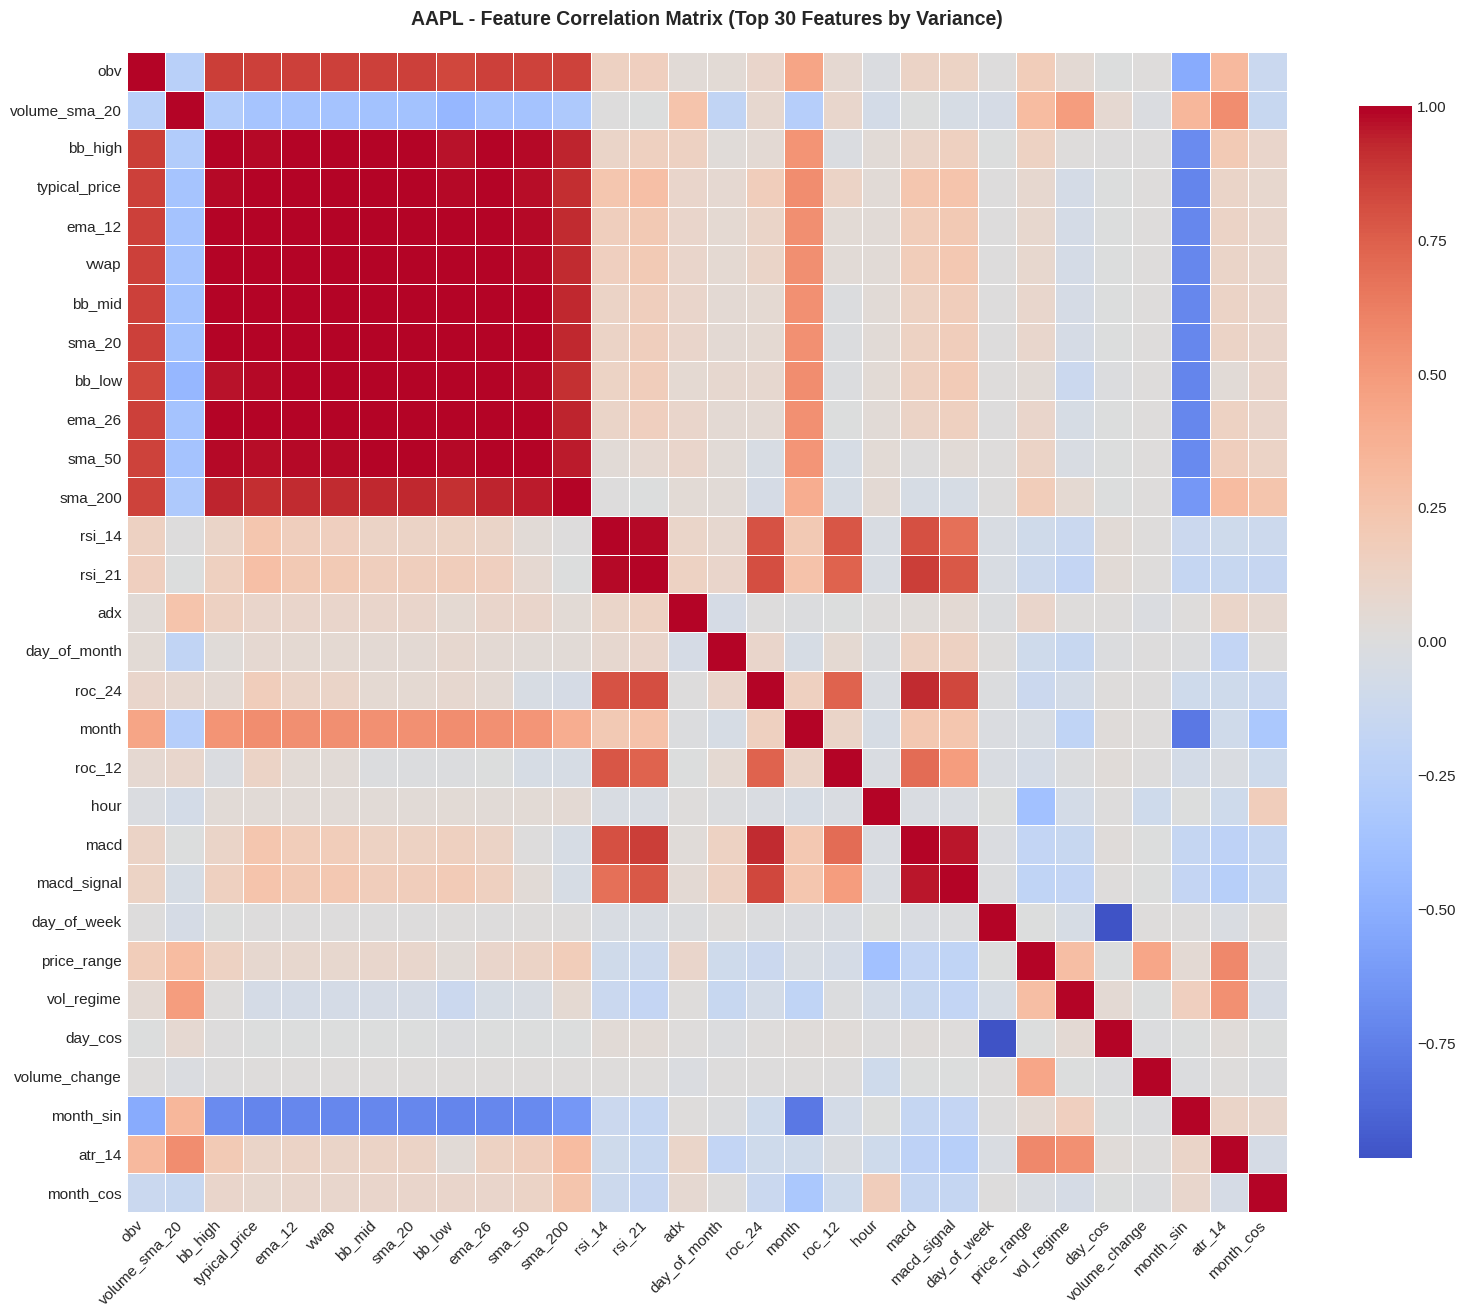

[OK] Correlation heatmap saved


In [37]:
# Plot correlation heatmap (top features by variance)
# Select top 30 features with highest variance
feature_variance = final_data[sample_asset][feature_cols].var().sort_values(ascending=False)
top_features = feature_variance.head(30).index.tolist()

fig, ax = plt.subplots(figsize=(16, 14))
corr_subset = correlation_matrix.loc[top_features, top_features]
sns.heatmap(corr_subset, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            xticklabels=True, yticklabels=True)
ax.set_title(f'{sample_asset} - Feature Correlation Matrix (Top 30 Features by Variance)', 
             fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}feature_correlation_{sample_asset}.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Correlation heatmap saved")

In [38]:
# Find highly correlated feature pairs (|correlation| > 0.9)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.9:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': corr_value
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False, key=abs)
    print(f"\nHighly Correlated Feature Pairs (|r| > 0.9) for {sample_asset}:")
    print("="*80)
    print(high_corr_df.to_string(index=False))
    print(f"\nTotal pairs: {len(high_corr_pairs)}")
else:
    print(f"\nNo highly correlated feature pairs (|r| > 0.9) found for {sample_asset}")


Highly Correlated Feature Pairs (|r| > 0.9) for AAPL:
        Feature 1             Feature 2  Correlation
      hist_vol_20       realized_vol_20     1.000000
           sma_20                bb_mid     1.000000
high_to_low_ratio       price_range_pct     0.999758
           ema_12                  vwap     0.999598
           sma_20                ema_26     0.999221
           ema_26                bb_mid     0.999221
           roc_24 cumulative_returns_24     0.998937
           sma_20                  vwap     0.998267
           bb_mid                  vwap     0.998267
           ema_12                bb_mid     0.997961
           sma_20                ema_12     0.997961
           ema_12                ema_26     0.997710
           ema_26                  vwap     0.997516
    typical_price                ema_12     0.996127
    typical_price                  vwap     0.994881
           sma_50                ema_26     0.992803
           ema_26               bb_high     

## 7. Feature-Target Correlation Analysis

Analyze which features have the strongest correlation with target variables.

In [39]:
# Calculate feature-target correlations
def calculate_feature_target_correlation(df, horizon):
    """
    Calculate correlation between features and target variable.
    """
    target_col = f'target_{horizon}'
    if target_col not in df.columns:
        return None
    
    feature_cols = get_feature_columns(df)
    correlations = df[feature_cols].corrwith(df[target_col]).sort_values(ascending=False, key=abs)
    
    return correlations

# Calculate for all horizons
horizons = PREDICTION_HORIZONS['stocks']
feature_target_corr = {}

print(f"Feature-Target Correlations for {sample_asset}:")
print("="*80)

for horizon_name in horizons.keys():
    corr = calculate_feature_target_correlation(final_data[sample_asset], horizon_name)
    if corr is not None:
        feature_target_corr[horizon_name] = corr
        
        print(f"\n{horizon_name.upper()} Prediction Horizon:")
        print("-" * 60)
        print("Top 10 Positively Correlated Features:")
        print(corr.head(10).to_string())
        print("\nTop 10 Negatively Correlated Features:")
        print(corr.tail(10).to_string())

Feature-Target Correlations for AAPL:

1HOUR Prediction Horizon:
------------------------------------------------------------
Top 10 Positively Correlated Features:
bb_position              -0.045770
returns_lag_1            -0.040901
rsi_14                   -0.033727
rsi_21                   -0.031119
is_market_hours           0.028299
close_to_vwap            -0.028287
vol_regime                0.027200
cumulative_returns_168   -0.026055
volume_ratio             -0.024739
hour                      0.024737

Top 10 Negatively Correlated Features:
vwap               0.001906
price_range_pct    0.001734
sma_20             0.001727
bb_mid             0.001727
price_range        0.001596
bb_low             0.001251
ema_12             0.001043
typical_price     -0.001042
returns            0.000350
returns_lag_24     0.000109

1HOUR Prediction Horizon:
------------------------------------------------------------
Top 10 Positively Correlated Features:
bb_position              -0.045770
ret

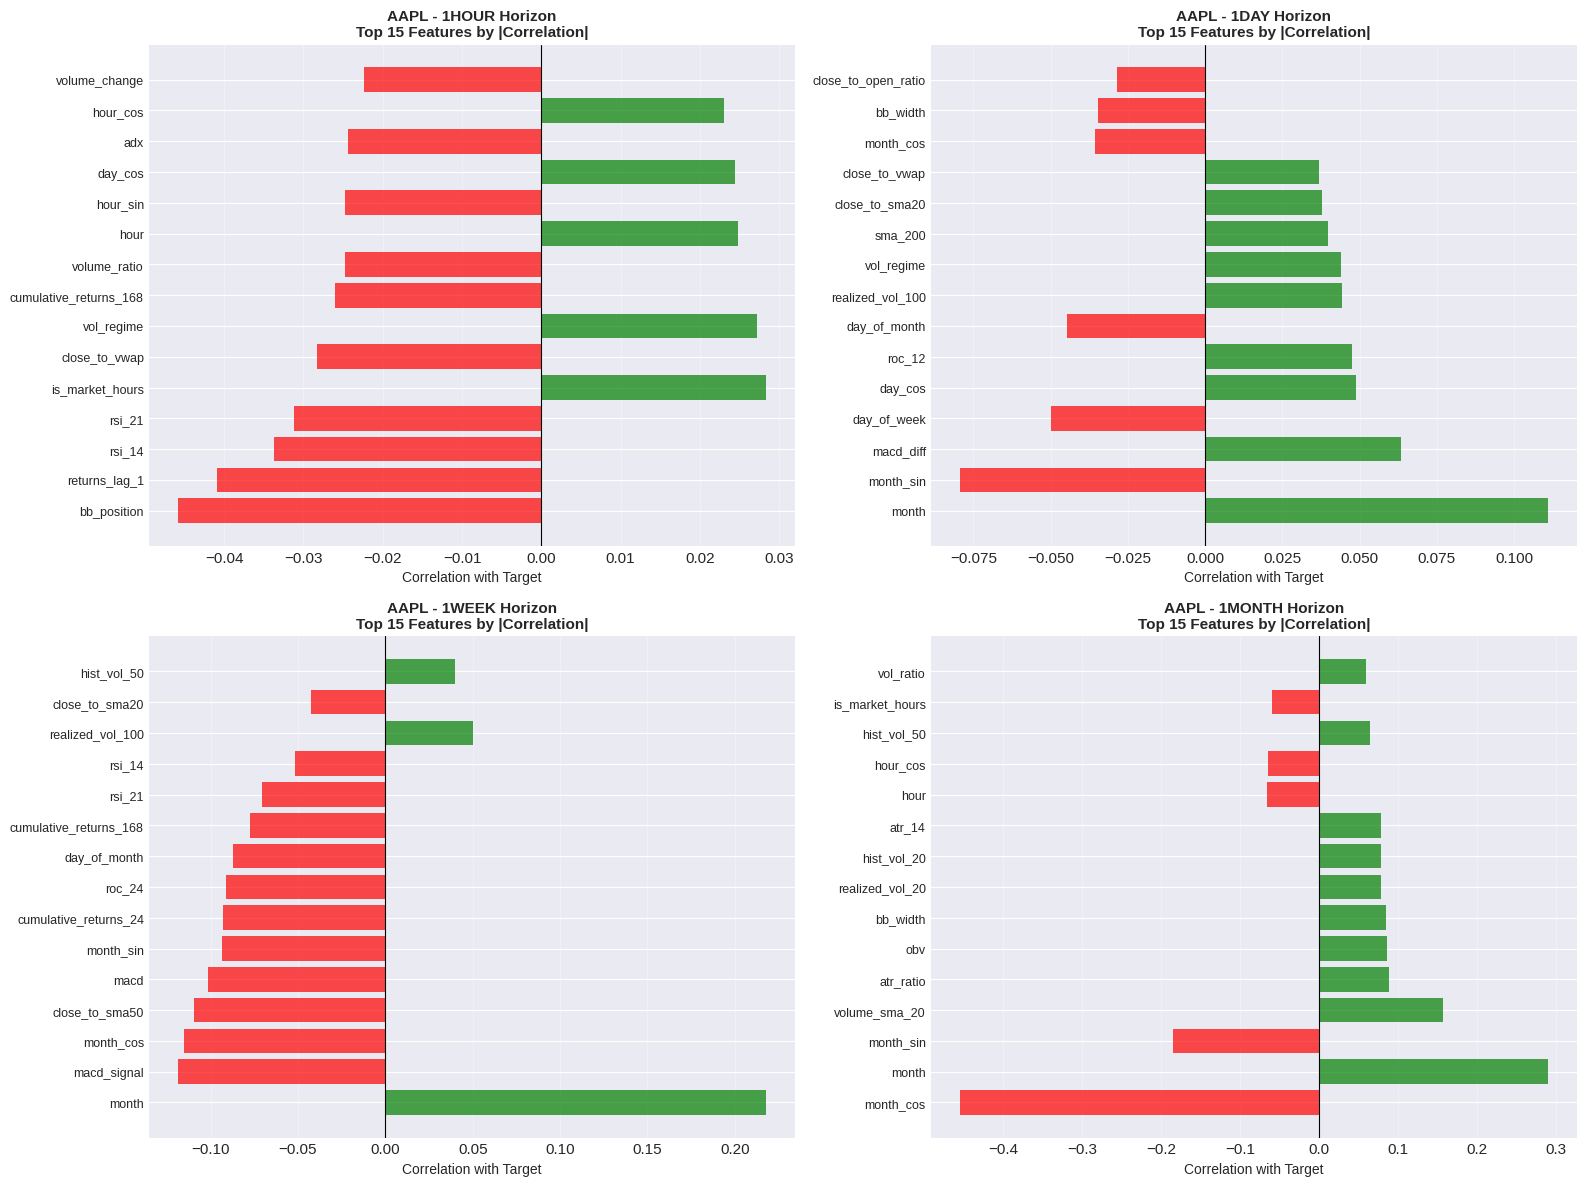

[OK] Feature-target correlation plots saved


In [40]:
# Visualize top feature-target correlations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (horizon_name, corr) in enumerate(feature_target_corr.items()):
    ax = axes[idx]
    
    # Get top 15 features by absolute correlation
    top_features = corr.abs().sort_values(ascending=False).head(15)
    top_corr_values = corr[top_features.index]
    
    # Create bar plot
    colors = ['green' if x > 0 else 'red' for x in top_corr_values]
    ax.barh(range(len(top_corr_values)), top_corr_values.values, color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_corr_values)))
    ax.set_yticklabels(top_corr_values.index, fontsize=9)
    ax.set_xlabel('Correlation with Target', fontsize=10)
    ax.set_title(f'{sample_asset} - {horizon_name.upper()} Horizon\nTop 15 Features by |Correlation|', 
                 fontsize=11, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}feature_target_correlation_{sample_asset}.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Feature-target correlation plots saved")

## 8. Save Processed Data

Save the engineered features and target variables to disk for use in model training.

In [41]:
print("="*80)
print("SAVING PROCESSED DATA")
print("="*80)

for asset, df in final_data.items():
    # Save full dataset with all features and targets
    filename = f'{PROCESSED_DIR}{asset}_features.csv'
    df.to_csv(filename)
    
    print(f"\n{asset}:")
    print(f"  Saved: {filename}")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {len(df.columns)}")
    print(f"  Date range: {df.index.min()} to {df.index.max()}")

print("\n" + "="*80)
print("[OK] All processed data saved successfully")
print("="*80)
print(f"\nOutput directory: {PROCESSED_DIR}")

SAVING PROCESSED DATA

AAPL:
  Saved: ../data/processed/AAPL_features.csv
  Shape: (3141, 68)
  Columns: 68
  Date range: 2024-01-22 17:30:00+00:00 to 2025-11-06 16:30:00+00:00

AAPL:
  Saved: ../data/processed/AAPL_features.csv
  Shape: (3141, 68)
  Columns: 68
  Date range: 2024-01-22 17:30:00+00:00 to 2025-11-06 16:30:00+00:00

AMZN:
  Saved: ../data/processed/AMZN_features.csv
  Shape: (3141, 68)
  Columns: 68
  Date range: 2024-01-22 17:30:00+00:00 to 2025-11-06 16:30:00+00:00

AMZN:
  Saved: ../data/processed/AMZN_features.csv
  Shape: (3141, 68)
  Columns: 68
  Date range: 2024-01-22 17:30:00+00:00 to 2025-11-06 16:30:00+00:00

NVDA:
  Saved: ../data/processed/NVDA_features.csv
  Shape: (3141, 68)
  Columns: 68
  Date range: 2024-01-22 17:30:00+00:00 to 2025-11-06 16:30:00+00:00

NVDA:
  Saved: ../data/processed/NVDA_features.csv
  Shape: (3141, 68)
  Columns: 68
  Date range: 2024-01-22 17:30:00+00:00 to 2025-11-06 16:30:00+00:00

BTC:
  Saved: ../data/processed/BTC_features.cs

## 9. Summary Statistics

Display comprehensive summary of the feature engineering process.

In [42]:
# Create summary table
summary_data = []

for asset, df in final_data.items():
    feature_cols = get_feature_columns(df)
    target_cols = [col for col in df.columns if col.startswith('target_')]
    
    summary_data.append({
        'Asset': asset,
        'Total_Rows': len(df),
        'Total_Columns': len(df.columns),
        'Feature_Columns': len(feature_cols),
        'Target_Columns': len(target_cols),
        'Date_Start': df.index.min(),
        'Date_End': df.index.max(),
        'File_Size_MB': os.path.getsize(f'{PROCESSED_DIR}{asset}_features.csv') / (1024**2)
    })

summary_df = pd.DataFrame(summary_data)

print("="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("[OK] Feature Engineering Complete!")
print("="*80)
print(f"\nTotal visualizations saved: 2")
print(f"Location: {FIGURES_DIR}")
print(f"\nProcessed data files: {len(final_data)}")
print(f"Location: {PROCESSED_DIR}")
print("\nReady to proceed with Data Preprocessing (Notebook 03)")

FEATURE ENGINEERING SUMMARY
Asset  Total_Rows  Total_Columns  Feature_Columns  Target_Columns                Date_Start                  Date_End  File_Size_MB
 AAPL        3141             68               58               4 2024-01-22 17:30:00+00:00 2025-11-06 16:30:00+00:00      3.463563
 AMZN        3141             68               58               4 2024-01-22 17:30:00+00:00 2025-11-06 16:30:00+00:00      3.460915
 NVDA        3141             68               58               4 2024-01-22 17:30:00+00:00 2025-11-06 16:30:00+00:00      3.451738
  BTC       16601             67               58               4       2023-12-16 02:00:00       2025-11-06 18:00:00     17.069693

[OK] Feature Engineering Complete!

Total visualizations saved: 2
Location: ../results/figures/feature_engineering/

Processed data files: 4
Location: ../data/processed/

Ready to proceed with Data Preprocessing (Notebook 03)
